# Spotřeba vlaků
### Cesta k pochopení a vypočtení

## Plán do příští iterace
#### ETA: 6.2.2023
- Vypočítat tečnou sílu
- Vypočítat zrychlení z tečné síly
- Odečíst gravitační zrychlení (podle sklonu) od získaného zrychlení
- Limitovat výsledky výkonem lokomotivy

## Prolog

Celý svůj průzkum a testování jsem záměrně zanesl do Jupyter Notebooku, abych nyní mohl jednoduše komentovat postup. Všechny postřehy, domněnky a další myšlenky jsou tedy uvedeny společně s demonstračním kódem dále.

Tady by se ještě hodilo zmínit, že v žádném případě netvrdím, že cokoliv z těchto pokusů je správně. Naopak jsem přesvědčen, že z neznalosti a možného opomenutí pro ostříleného fyzika naprosto elementárních faktů se mi mohlo podařit naprosto sejít z cesty. Poprosil bych tedy o skeptický náhled a případné upozornění na postřehy naprosto mimo mísu.

## Zdroje
> https://www.movable-type.co.uk/scripts/latlong.html
<br>
> https://boulter.com/gps/distance/?from=49.97212553+17.860912499&to=49.972125524+17.860912502&units=k
<br>
> https://pressbooks.bccampus.ca/physics0312chooge/chapter/2-4-acceleration/
<br>
> https://www.quora.com/How-do-you-find-final-velocity-from-acceleration-and-distance
<br>
> https://www.quora.com/How-do-I-calculate-the-final-velocity-based-on-distance-and-acceleration-with-the-initial-velocity-being-0-What-is-the-formula
<br>
> https://www.real-world-physics-problems.com/work-and-energy.html
<br>
> https://energyeducation.ca/encyclopedia/Energy_vs_power
<br>
> https://www.khanacademy.org/science/in-in-class11th-physics/in-in-class11th-physics-work-energy-and-power/in-in-class11-work-energy-theorem/a/work-energy-theorem-ap1
<br>
> https://en.wikipedia.org/wiki/Equations_of_motion#Uniform_acceleration
<br>
> https://www.shorttutorials.com/how-to-calculate-power/given-mass-acceleration-velocity.html
<br>
> https://mdpi-res.com/d_attachment/energies/energies-15-04256/article_deploy/energies-15-04256-v2.pdf?version=1654851864
<br>
> https://gis.stackexchange.com/questions/414166/create-points-along-lines-at-defined-distance-in-postgis

## Importy

In [1]:
import json
import math
import matplotlib.pyplot as plt

## Konstanty

- *G_TO_MS2* je konstanta gravitačního zrychlení
- *TRAIN_ACC_G* a *TRAIN_DEC_G* jsou vlaku zrychlení při rozjezdu a při brždění
    - Tyto hodnoty byly zvoleny, protože jsem v diskuzi na fóru vypozoroval, že pokud by zrychlení bylo vyšší, tak by pravděpodobně začali lítat pasažeři (což se obyčejně neděje)
    - Zrychlení (a "zpomalení") by pravděpodobně nemělo být konstantní hodnotou, ale asi by mohlo být reprezentováno nějakým profilem, který by mohl jít vypočítat z údajů z datasheetu lokomotivy - toto je momentálně moc komplexní problém, dostatečně tomu nerozumím

In [2]:
G_TO_MS2 = 9.80665
TRAIN_ACC_G = 0.1
TRAIN_ACC_MS2 = TRAIN_ACC_G * G_TO_MS2
TRAIN_DEC_G = 0.12
TRAIN_DEC_MS2 = TRAIN_DEC_G * G_TO_MS2

## Funkce

### Utility

In [3]:
def parse_points_from_geojson(geojson_raw):
    geojson = json.loads(geojson_raw)
    return geojson["coordinates"]

> Tato funkce bere string ve tvaru GeoJSON a vytahuje z něj jednotlivé body trasy. Ve finální implementaci se toto bude tahat rovnou z databáze.

### Vzorce

In [4]:
# https://www.movable-type.co.uk/scripts/latlong.html
def calc_distance_two_points(point_a, point_b):
    R = 6371e3 # meters
    φ1 = point_a[1] * math.pi/180 # φ, λ in radians
    φ2 = point_b[1] * math.pi/180
    Δφ = (point_b[1]-point_a[1]) * math.pi/180
    Δλ = (point_b[0]-point_a[0]) * math.pi/180
    
    a = math.sin(Δφ/2) * math.sin(Δφ/2) + math.cos(φ1) * math.cos(φ2) * math.sin(Δλ/2) * math.sin(Δλ/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return R * c # meters

> Tato funkce počítá vzdálenost mezi dvěma body (ve 2D). Je podstatné zmínit, že toto funguje pouze s klasickými GPS (WGS 84) souřadnicemi a ne s Křovákovým zobrazením, ve kterém jsou data od SŽ. Takže je nutný převod, který PostGIS umí a stejně tu vzdálenost nakonec bude pravděpodobně počítat rovnou databáze.

In [5]:
def calc_kinetic_energy(mass, velocity):
    return (mass*velocity**2)/2

> Vzorec pro výpočet kinetické energie: $ E_K = \frac{1}{2}mv^2 $

In [6]:
def calc_potential_energy(mass, height):
    return mass*G_TO_MS2*height

> Vzorec pro výpočet potenciální energie: $ E_P = mgh $

In [7]:
def calc_velocity(acceleration, distance, init_velocity=0):
    return math.sqrt(init_velocity**2 + 2*acceleration*distance)

> Vzorec pro výpočet rychlosti: $ v = \sqrt{u^2 + 2as} $
<br>
> Jedná se o tzv. *Thrird equation of motion* - předpokládám, že lze aplikovat tady, protože počítáme s konstantním zrychlením
<br>
> https://brilliant.org/wiki/laws-of-motion/

In [8]:
def calc_distance(acceleration, velocity, init_velocity=0):
    return (velocity**2-init_velocity**2)/(2*acceleration)

> Vzorec z předešlé funkce, akorát přepsaný, aby vracel vzdálenost: $ s = \frac{v^2 - u^2}{2a} $
<br>
> V programu se tato varianta vzorce nakonec nepoužívá

### Aplikace vzorců na body trati (v cyklu)

In [9]:
def get_elevation_slope_sin_old(point_a, point_b, dist):
    elevation_delta = point_b[2] - point_a[2] # NOTE: incline specific
    slope_distance = math.sqrt(elevation_delta**2 + dist**2)
    # print(slope_distance)
    return elevation_delta/slope_distance, slope_distance

> Tato funkce vezme dva body a vzdálenost mezi nimi

![Bez názvu.png](attachment:4c917d75-8325-4f15-9056-651518566a94.png)

> Vypočítá rozdíl mezi elevací dvou bodů (b v obrázku), který použije pro získání sinu úhlu elevace (modrý úhel v obrázku) $\rightarrow$ návratová hodnota
<br>
> Zároveň vypočítá novou vzdálenost mezi body (a v obrázku), která uvažuje změnu v elevaci $\rightarrow$ návratová hodnota

In [10]:
def get_acceleration(points, max_velocity):   
    dist_values = [0]
    velocity_values = [0]
    acceleration_values = [0]
    angle_sin_values = [0]
    
    dist = 0
    velocity_reached = False
    for i in range(len(points)-1):
        immediate_distance = calc_distance_two_points(points[i], points[i+1])
        angle_sin, slope_distance = get_elevation_slope_sin_old(points[i], points[i+1], immediate_distance)
        angle_sin_values.append(angle_sin)
        dist += slope_distance
        if not velocity_reached:
            acceleration_values.append(TRAIN_ACC_MS2)
            velocity = calc_velocity(TRAIN_ACC_MS2, dist)
            if velocity >= max_velocity:
                velocity = max_velocity
                velocity_reached = True
        else:
            acceleration_values.append(0)
        dist_values.append(dist)
        velocity_values.append(velocity)
    return dist_values, velocity_values, acceleration_values, angle_sin_values

> Tato funkce dostane na vstupu body trati a maximální rychlost
<br>
> Pro každou po sobě jdoucí dvojici bodů se vypočítá/získá:
> - 2D vzdálenost
> - Vzdálenost s ohledem na změnu elevace + sinus úhlu spojeného s elevací
> - Rychlost na základě konstantního zrychlení
> - Zrychlení v daném bodě (možnosti: zrychlení / 0 / zpomalení)

> Kde se tento přístup jeví jako naivní:
> - Zrychlení je konstantní po celou dobu rozjezdu a při dosažení maximální rychlosti skočí na nulu
> - Vlak na začátku zrychluje a po dosažení maximální rychlosti na trati se jí perfektně drží
> - Tření je imaginární koncept

In [11]:
def get_deceleration(points, max_velocity):
    dist = 0
    end_velocity = [0]
    for i in range(len(points)-1,0,-1):
        dist = dist + calc_distance_two_points(points[i], points[i-1])
        velocity = calc_velocity(TRAIN_DEC_MS2, dist)
        if velocity >= max_velocity:
            break
        end_velocity.append(velocity)
    return end_velocity

> Tato funkce počítá pouze rychlost a to pro posledních několik metrů cesty
<br>
> Funguje obdobně jako předchozí a slouzí pouze k doplnění brždění vlaku

In [12]:
def get_complete_velocity(points, max_velocity):
    dist_values, velocity_values, acceleration_values, angle_sin_values = get_acceleration(points, max_velocity)
    end_velocity = get_deceleration(points, max_velocity)
    for i in range(len(end_velocity)):
        velocity_values[-i-1] = end_velocity[i]
        acceleration_values[-i-1] = -TRAIN_DEC_MS2
    return dist_values, velocity_values, acceleration_values, angle_sin_values

> Tato funkce pouze vezme hodnoty ze dvou předchozích a udělá z nich jeden celek
<br>
> Na konci je tedy mimo jiné možné vygenerovat graf rychlosti po celé trati, kde vlak nejdřívě zrychluje, potom urdžuje konstantní rychlost a následně zpomalí

In [13]:
def get_kinetic_energy(mass, velocity_values):
    return [calc_kinetic_energy(mass, v) for v in velocity_values]

> Tato funkce na vstupu dostane hmotnost a hodnoty rychlosti
<br>
> Vrátí pro každou hodnotu rychlosti hodnotu kinetické energie podle vzorce: $ E_K = \frac{1}{2}mv^2 $

In [14]:
def get_potential_energy(mass, points):
    return [calc_potential_energy(mass, p[2]) for p in points]

> Tato funkce na vstup dostane hmotnost a body trati
<br>
> Vrátí pro každou hodnotu výšky hodnotu potenciální energie podle vzorce $ E_P = mgh $ 

In [15]:
def get_normalized_potential_energy(potential_energy):
    return [e-potential_energy[0] for e in potential_energy]

> Tato funkce na vstup dostane hodnoty potenciální energie
<br>
> Vrátí hodnoty *normalizované* podle počáteční (protože je pro nás podstatná pouze relativní změna)

In [16]:
def get_work(energy_values):
    return [energy_values[i+1]-x for i,x in enumerate(energy_values) if i < len(energy_values)-1]

> Tato funkce na vstupu dostane hodnoty energie
<br>
> Vrátí pro každou dvojici na indexu *i* a *i+1* hodnotu vykonané práce podle vzorce: $ W = \Delta E = E_{i+1} - E_{i} $
<br>
> **Poznámka:** Aktuálně se nepoužívá

In [17]:
def get_power(mass, acceleration_values, angle_sin_values, velocity_values):
    return [(mass*a + mass*G_TO_MS2*angle_sin_values[i])*velocity_values[i] for i,a in enumerate(acceleration_values)]

> Tato funkce na vstupu dostane hmotnost, hodnoty zrychlení, hodnoty sinů úhlů sklonu při elevaci a hodnoty rychlosti
<br>
> Vrátí list hodnot výkonu, kdy každou hodnotu v něm vypočítá podle tohoto vzorce: $ P = Fv = (F_{Lokomotiva} + F_{Gravitace})v = (ma + mg\sin{\alpha})v $

In [18]:
def draw_plot(dist_values, highlight_zero, *args):
    fig=plt.figure(figsize=(20,4), dpi= 100)
    plt.xlabel("Vzdálenost (m)")
    if highlight_zero:
        plt.axhline(y=0, color="grey", linestyle="dotted")
    for line in args:
        if line["scatter"]:
            plt.scatter(dist_values, kwargs[line], label=line, marker="o")
        else:
            plt.plot(dist_values, line["values"], label=line["name"])
    plt.legend()
    plt.show()

## Spuštění testovacího případu

Aktuálně je nutné vložit jako vstup trať, která má každé dva sousední body ekvidistantní (což pro původní SŽ data neplatí).
<br>
Výběr takových bodů by mělo být možné pomocí PostGISu uskutečnit. Zatím práce s exportem z programu QGIS, který tuto funkcionalitu nabízí.

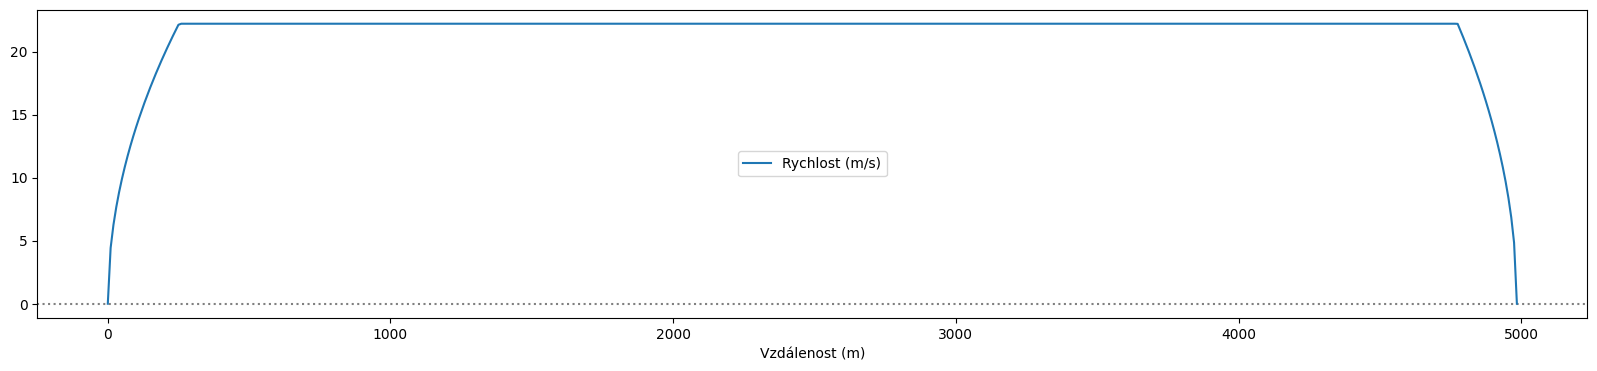

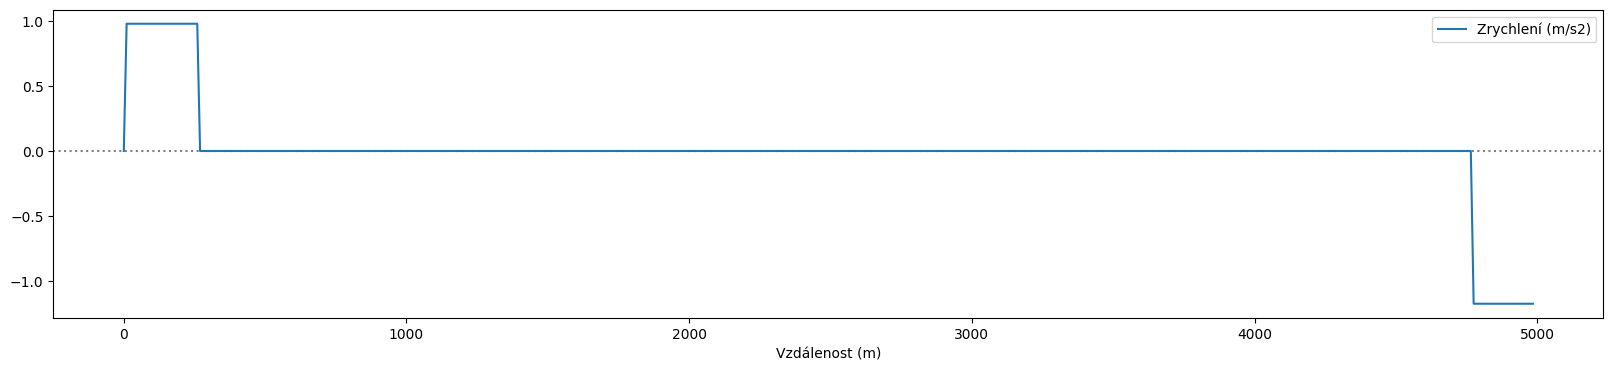

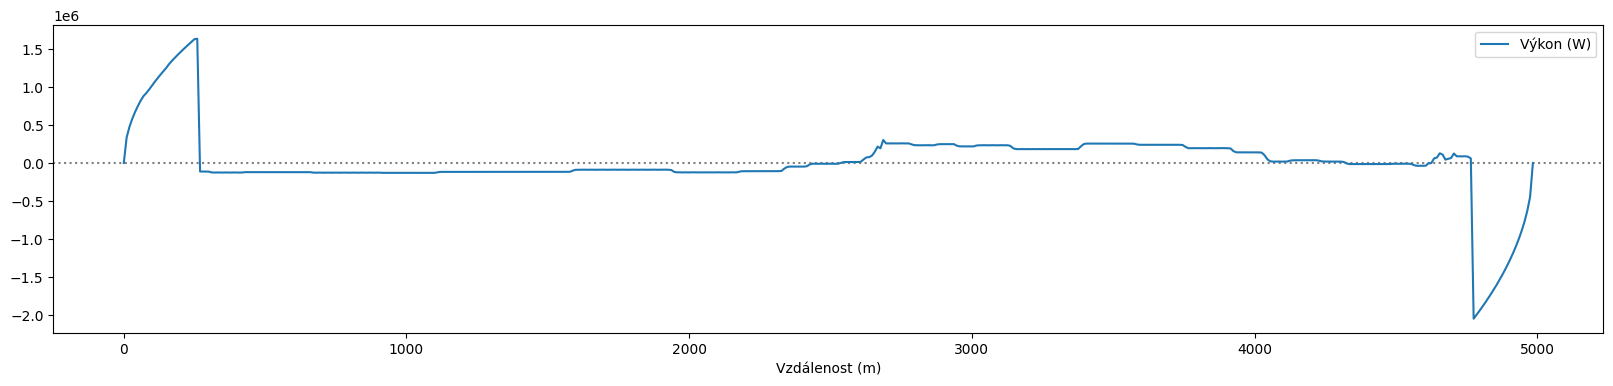

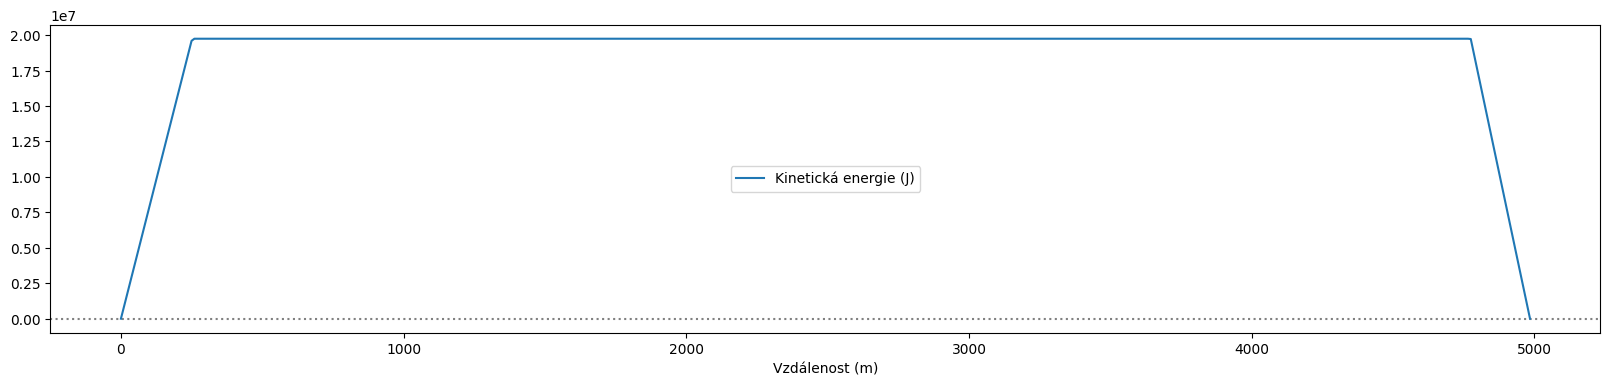

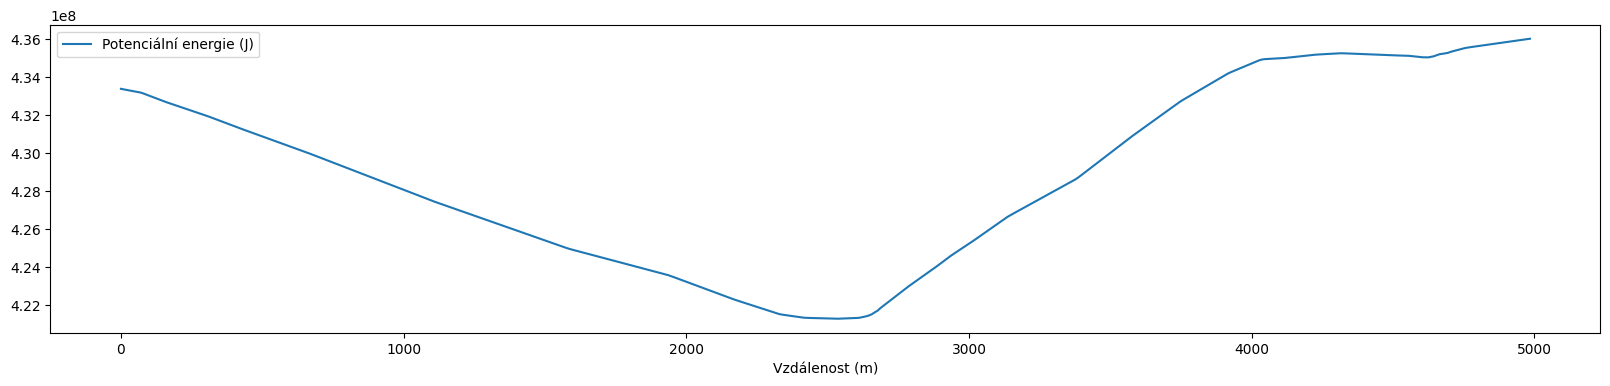

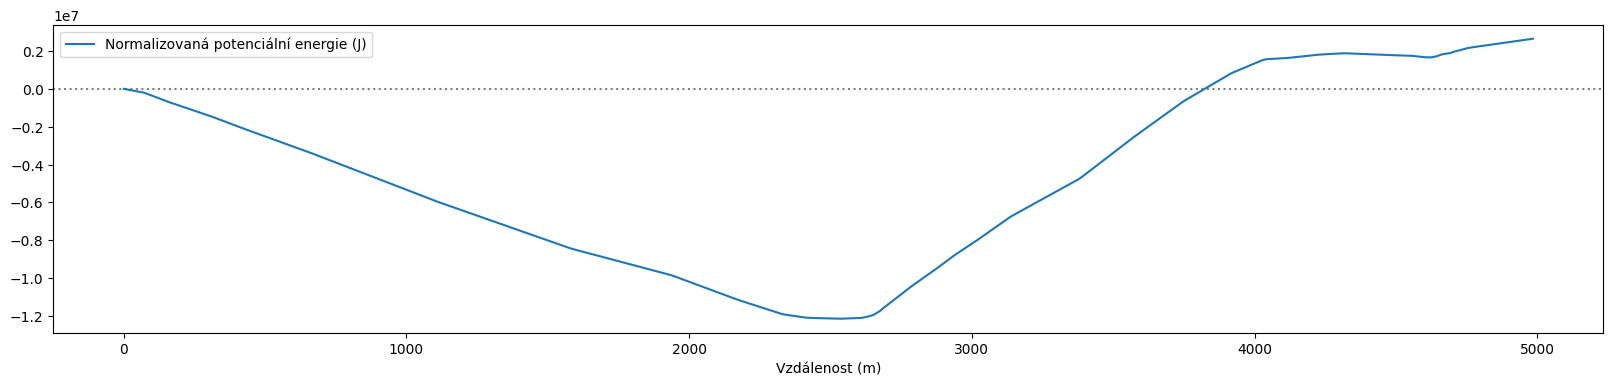

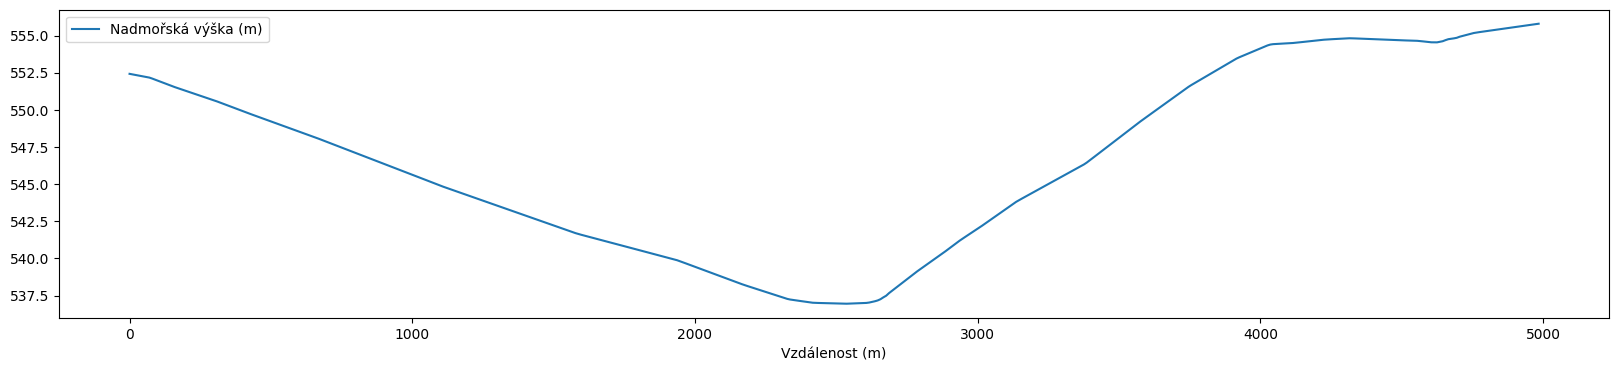

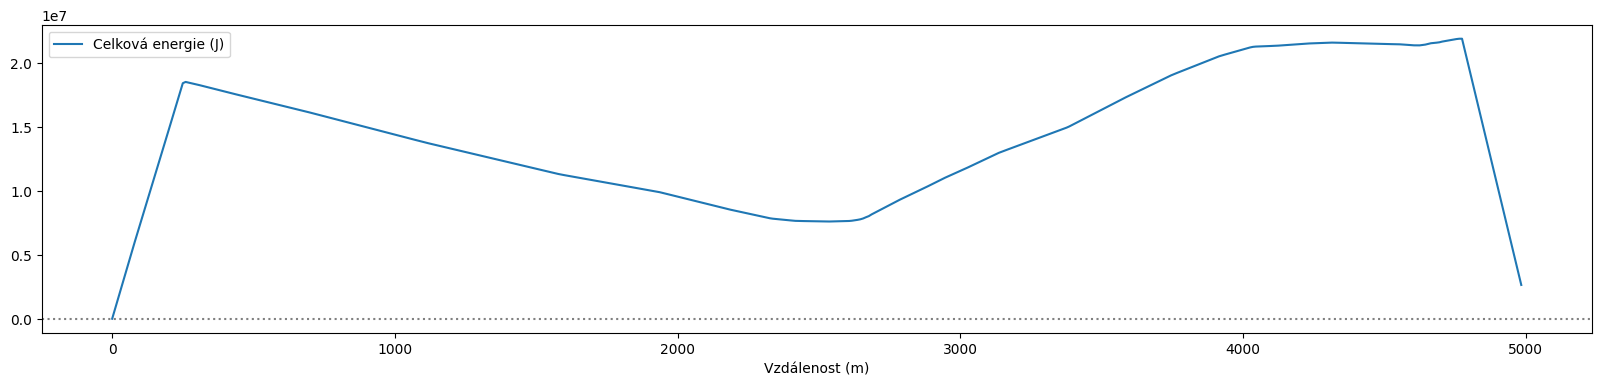

In [19]:
with open("spaced.geojson") as f:
    lines = f.readlines()
    points = parse_points_from_geojson("".join(lines))
    # Remove zeros
    for i in range(len(points)):
        if i == 0:
            continue
        if points[i][2] < points[i-1][2]*0.9:
            points[i] = [points[i][0],points[i][1],points[i-1][2]]

# Show only part of the track
points = points[6000:6500]
# points = [[x[0], x[1], 100] for x in points]
# print(len(points))

max_velocity = 22.22 # m/s
mass = 80000 # kg

dist_values, velocity_values, acceleration_values, angle_sin_values = get_complete_velocity(points, max_velocity)
k_energy_values = get_kinetic_energy(mass, velocity_values)
p_energy_values = get_potential_energy(mass, points)
norm_p_energy_values = get_normalized_potential_energy(p_energy_values) 
power_values = get_power(mass, acceleration_values, angle_sin_values, velocity_values)

# Plots
draw_plot(dist_values, True, {"values": velocity_values, "name": "Rychlost (m/s)", "scatter": False})
draw_plot(dist_values, True, {"values": acceleration_values, "name": "Zrychlení (m/s2)", "scatter": False})
draw_plot(dist_values, True, {"values": power_values, "name": "Výkon (W)", "scatter": False})
draw_plot(dist_values, True, {"values": k_energy_values, "name": "Kinetická energie (J)", "scatter": False})
draw_plot(dist_values, False, {"values": p_energy_values, "name": "Potenciální energie (J)", "scatter": False})
draw_plot(dist_values, True, {"values": norm_p_energy_values, "name": "Normalizovaná potenciální energie (J)", "scatter": False})
draw_plot(dist_values, False, {"values": [x[2] for x in points], "name": "Nadmořská výška (m)", "scatter": False})
draw_plot(dist_values, True, {"values": [k_energy_values[i]+norm_p_energy_values[i] for i in range(len(k_energy_values))], "name": "Celková energie (J)", "scatter": False})

## Epilog

Takto vypadá můj dosavadní průzkum. Všechno to stojí na velmi základních vzorcích. Ale za předpokladu, že jsou moje pochody o tom, jak věci fungují, alespoň trochu správné, tak by to pro začátek mohlo stačit.
<br>
Narazil jsem na odbornou práci, která se věnuje metodologii odhadování vlakové spotřeby, ale zatím nejsem schopen ani začít uvažovat o tom, jak se do něčeho takového ponořit. Přikládám [ODKAZ](https://mdpi-res.com/d_attachment/energies/energies-15-04256/article_deploy/energies-15-04256-v2.pdf?version=1654851864) pro případnou budoucí referenci.
<br>
A nakonec si tady ještě odložím jeden zdroj (odkaz [ZDE](http://evilgeniustech.com/idiotsGuideToRailroadPhysics/)), který jsem sice nepoužil, ale pokud dojde na studium dokumentace a dolování konkrétních parametrů lokomotiv, tak by se mohl hodit.

## >> WIP <<
> https://web.archive.org/web/20200526222719/http://www.kves.uniza.sk/kvesnew/dokumenty/et/ET%20skripta%20Danzer/ETR700.pdf
<br>
> https://www.youtube.com/watch?v=cPMSMDSY-rc

In [20]:
def calc_normal_force(mass, angle_cos):
    return mass*G_TO_MS2*angle_cos

In [21]:
def calc_parallel_g_force(mass, angle_sin):
    return mass*G_TO_MS2*angle_sin

In [22]:
def calc_adhesion_ck(velocity):
    return 7500/(velocity+44)+161 #μ_max

In [23]:
def calc_tangential_force(mass, angle_cos, velocity):
    velocity_in_kph = velocity*3.6
    normal_force_in_kn = calc_normal_force(mass, angle_cos)/1000
    return normal_force_in_kn*calc_adhesion_ck(velocity_in_kph)

In [24]:
def calc_acceleration(force, mass):
    return force/mass

In [25]:
def get_elevation_slope_cos(point_a, point_b, dist):
    elevation_delta = point_b[2] - point_a[2]
    slope_distance = math.sqrt(elevation_delta**2 + dist**2)
    return dist/slope_distance, slope_distance

In [26]:
def get_elevation_slope_sin(point_a, point_b, dist):
    elevation_delta = abs(point_b[2] - point_a[2])
    slope_distance = math.sqrt(elevation_delta**2 + dist**2)
    return elevation_delta/slope_distance, slope_distance

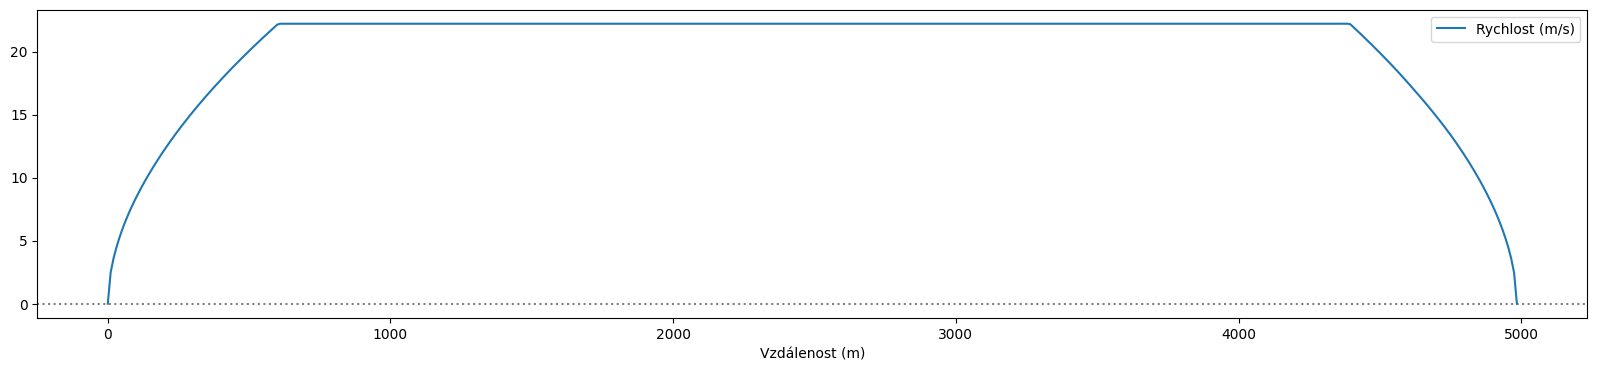

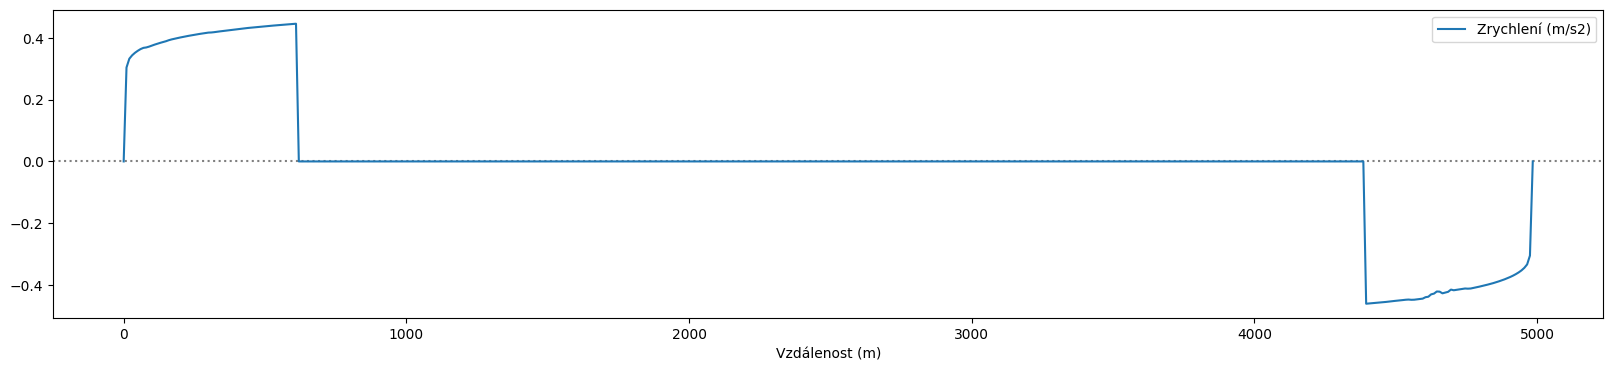

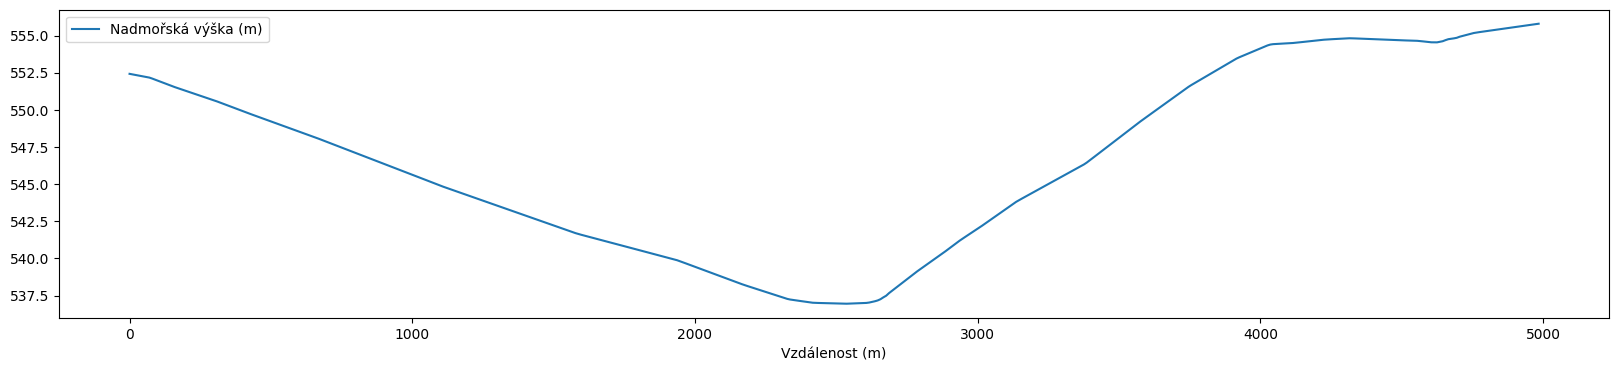

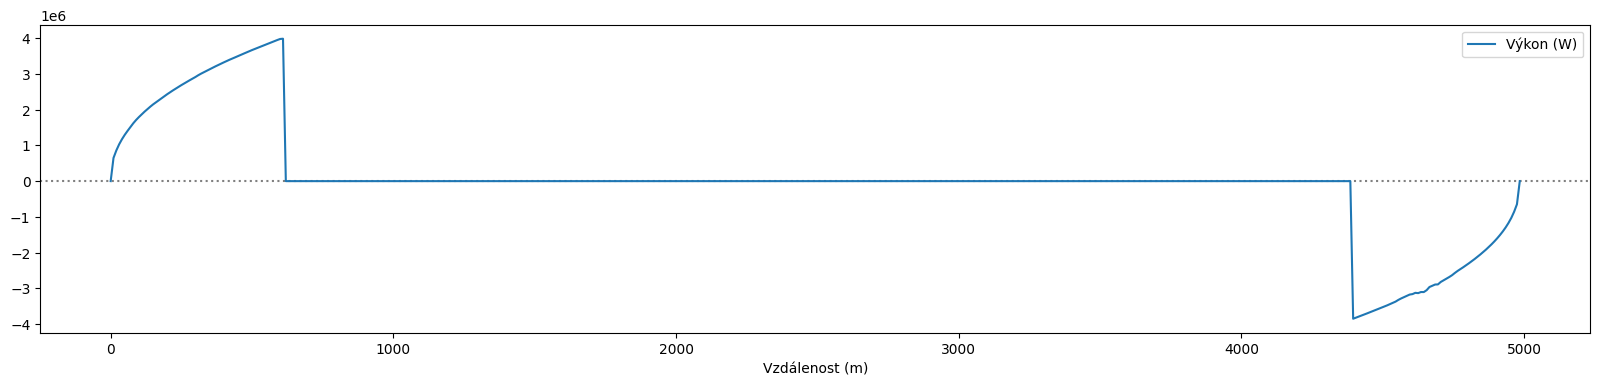

In [27]:
def get_ramp_up(mass, points, max_velocity):
    force_values = [0]
    velocity_values = [0]
    dist_values = [0]
    acceleration_values = [0]
    velocity_reached = False
    
    for i in range(len(points)-1):
        immediate_distance = calc_distance_two_points(points[i], points[i+1])
        angle_cos, slope_distance = get_elevation_slope_cos(points[i], points[i+1], immediate_distance)
        tangential_force = calc_tangential_force(mass, angle_cos, velocity_values[-1])
        angle_sin = get_elevation_slope_sin(points[i], points[i+1], immediate_distance)[0]
        parallel_g_force = calc_parallel_g_force(mass, angle_sin)
        # print(tangential_force+parallel_g_force, tangential_force, parallel_g_force)
        
        
        
        if not velocity_reached:
            # Is it incline/decline?
            if points[i+1][2] - points[i][2] > 0: # Incline
                final_force = tangential_force - parallel_g_force
            else: # Decline
                final_force = tangential_force + parallel_g_force
            acceleration = calc_acceleration(mass, final_force)
            new_velocity = calc_velocity(acceleration, slope_distance, velocity_values[-1])
            if new_velocity >= max_velocity:
                new_velocity = max_velocity
                velocity_reached = True
        else:
            final_force = 0
            acceleration = 0 # NOTE: If no change in speed, acceleration is ZERO
        # print("acc", acceleration, slope_distance, velocity_values[-1], new_velocity)
        force_values.append(final_force)
        velocity_values.append(new_velocity)
        dist_values.append(dist_values[-1]+slope_distance)
        acceleration_values.append(acceleration)
        # print(velocity_values[-1])
    return force_values, dist_values, velocity_values, acceleration_values

def get_ramp_down(mass, points, max_velocity):
    # dist = 0
    end_force = [0]
    end_velocity = [0]
    deceleration_values = [0]
    for i in range(len(points)-1,0,-1):
        immediate_distance = calc_distance_two_points(points[i], points[i-1])
        
        angle_cos, slope_distance = get_elevation_slope_cos(points[i-1], points[i], immediate_distance)
        tangential_force = calc_tangential_force(mass, angle_cos, end_velocity[-1])
        angle_sin = get_elevation_slope_sin(points[i-1], points[i], immediate_distance)[0]
        parallel_g_force = calc_parallel_g_force(mass, angle_sin)
        
        # Is it incline/decline?
        if points[i-1][2] - points[i][2] > 0: # Incline
            final_force = tangential_force - parallel_g_force
        else: # Decline
            final_force = tangential_force + parallel_g_force
        acceleration = calc_acceleration(mass, final_force)
        new_velocity = calc_velocity(acceleration, slope_distance, end_velocity[-1])
        # print("acc", acceleration, slope_distance, end_velocity[-1], new_velocity)
        if new_velocity >= max_velocity:
            break
        end_force.append(-final_force) # NOTE: Braking force has opposite direction
        end_velocity.append(new_velocity)
        deceleration_values.append(-acceleration) # NOTE: Deceleration has opposite direction
    return end_force, end_velocity, deceleration_values

def get_complete_run(mass, points, max_velocity):
    force_values, dist_values, velocity_values, acceleration_values = get_ramp_up(mass, points, max_velocity)
    end_force, end_velocity, deceleration_values = get_ramp_down(mass, points, max_velocity)
    for i in range(len(end_velocity)):
        force_values[-i-1] = end_force[i]
        velocity_values[-i-1] = end_velocity[i]
        acceleration_values[-i-1] = deceleration_values[i]
    return force_values, dist_values, velocity_values, acceleration_values

def get_power_raw(force_values, velocity_values):
    return [force_values[i]*velocity_values[i] for i in range(len(force_values))]
    
# RUNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
with open("spaced.geojson") as f:
    lines = f.readlines()
    points = parse_points_from_geojson("".join(lines))
    # Remove zeros
    for i in range(len(points)):
        if i == 0:
            continue
        if points[i][2] < points[i-1][2]*0.9:
            points[i] = [points[i][0],points[i][1],points[i-1][2]]

# Show only part of the track
points = points[6000:6500]

max_velocity = 22.22 # m/s
mass = 80000 # kg
force_values, dist_values, velocity_values, acceleration_values = get_complete_run(mass, points, max_velocity)
power_values = get_power_raw(force_values, velocity_values)

# print(velocity_values)
draw_plot(dist_values, True, {"values": velocity_values, "name": "Rychlost (m/s)", "scatter": False})
# print(acceleration_values)
draw_plot(dist_values, True, {"values": acceleration_values, "name": "Zrychlení (m/s2)", "scatter": False})
draw_plot(dist_values, False, {"values": [x[2] for x in points], "name": "Nadmořská výška (m)", "scatter": False})
draw_plot(dist_values, True, {"values": power_values, "name": "Výkon (W)", "scatter": False})

<br>
<hr>
<div style="text-align: center">&#169; Jan Němec 2023</div>